# Getting Started with correct_atmosphere

This notebook introduces the `correct_atmosphere` package, a Python implementation of NASA's Ocean Biology Processing Group (OBPG) atmospheric correction algorithms for ocean color remote sensing.

The package implements algorithms from **NASA Technical Memorandum TM-2016-217551** (Mobley et al., 2016) to convert top-of-atmosphere (TOA) radiances to water-leaving radiances and remote-sensing reflectances.

## Installation

Install the package in development mode:

```bash
pip install -e .
```

## Package Overview

The atmospheric correction process removes atmospheric effects from satellite ocean color observations to retrieve the water-leaving radiance, which contains information about ocean constituents (phytoplankton, sediments, dissolved organic matter).

### Supported Sensors

- SeaWiFS
- MODIS-Aqua
- MODIS-Terra
- VIIRS-NPP
- VIIRS-NOAA20

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Import the main package
import correct_atmosphere as ca
from correct_atmosphere import constants

## Physical Constants

The package provides standard physical constants used throughout the atmospheric correction process.

In [2]:
print(f"Standard Pressure: {constants.STANDARD_PRESSURE} hPa")
print(f"Standard Temperature: {constants.STANDARD_TEMPERATURE} K")
print(f"Mean Earth-Sun Distance: {constants.MEAN_EARTH_SUN_DISTANCE} AU")

Standard Pressure: 1013.25 hPa
Standard Temperature: 288.15 K
Mean Earth-Sun Distance: 1.0 AU


## Sensor Band Definitions

Each sensor has specific spectral bands with known characteristics. The package stores band-averaged values for Rayleigh optical thickness, gas absorption cross sections, and other parameters.

In [3]:
# Get band definitions for MODIS-Aqua
modis_bands = constants.get_sensor_bands('MODIS-Aqua')

print("MODIS-Aqua Bands:")
print("-" * 40)
for band_name, wavelength in modis_bands.items():
    print(f"  {band_name}: {wavelength} nm")

MODIS-Aqua Bands:
----------------------------------------
  412: (412.0, 405.0, 420.0) nm
  443: (443.0, 438.0, 448.0) nm
  469: (469.0, 459.0, 479.0) nm
  488: (488.0, 483.0, 493.0) nm
  531: (531.0, 526.0, 536.0) nm
  547: (547.0, 543.0, 553.0) nm
  555: (555.0, 545.0, 565.0) nm
  645: (645.0, 620.0, 670.0) nm
  667: (667.0, 662.0, 672.0) nm
  678: (678.0, 673.0, 683.0) nm
  748: (748.0, 743.0, 753.0) nm
  869: (869.0, 862.0, 877.0) nm


In [4]:
# Compare bands across sensors
#sensors = ['seawifs', 'modis_aqua', 'viirs_npp']
sensors = ['SeaWiFS', 'MODIS-Aqua', 'VIIRS-NPP']

print("Band Comparison Across Sensors:")
print("=" * 60)
for sensor in sensors:
    bands = constants.get_sensor_bands(sensor)
    wavelengths = list(bands.values())
    print(f"\n{sensor.upper()}:")
    print(f"  Wavelengths: {wavelengths}")

Band Comparison Across Sensors:

SEAWIFS:
  Wavelengths: [(412.0, 402.0, 422.0), (443.0, 433.0, 453.0), (490.0, 480.0, 500.0), (510.0, 500.0, 520.0), (555.0, 545.0, 565.0), (670.0, 660.0, 680.0), (765.0, 745.0, 785.0), (865.0, 845.0, 885.0)]

MODIS-AQUA:
  Wavelengths: [(412.0, 405.0, 420.0), (443.0, 438.0, 448.0), (469.0, 459.0, 479.0), (488.0, 483.0, 493.0), (531.0, 526.0, 536.0), (547.0, 543.0, 553.0), (555.0, 545.0, 565.0), (645.0, 620.0, 670.0), (667.0, 662.0, 672.0), (678.0, 673.0, 683.0), (748.0, 743.0, 753.0), (869.0, 862.0, 877.0)]

VIIRS-NPP:
  Wavelengths: [(412.0, 402.0, 422.0), (445.0, 436.0, 454.0), (488.0, 478.0, 498.0), (555.0, 545.0, 565.0), (672.0, 662.0, 682.0), (746.0, 739.0, 754.0), (865.0, 846.0, 885.0)]


## NIR Bands for Aerosol Correction

The atmospheric correction algorithm uses near-infrared (NIR) bands where water-leaving radiance is assumed to be negligible (black pixel assumption) to estimate aerosol contributions.

In [5]:
# Get NIR bands used for aerosol correction
for sensor in sensors:
    nir_bands = constants.get_nir_bands(sensor)
    print(f"{sensor}: NIR bands = {nir_bands}")

SeaWiFS: NIR bands = ('765', '865')
MODIS-Aqua: NIR bands = ('748', '869')
VIIRS-NPP: NIR bands = ('M6', 'M7')


## Rayleigh Optical Thickness

Band-averaged Rayleigh optical thicknesses are pre-computed for each sensor's bands. These values are used to correct for molecular (Rayleigh) scattering in the atmosphere.

In [6]:
# Get Rayleigh optical thickness for MODIS-Aqua bands
modis_rayleigh = constants.RAYLEIGH_OD['MODIS-Aqua']

print("MODIS-Aqua Rayleigh Optical Thickness:")
print("-" * 45)
for band, tau_r in modis_rayleigh.items():
    wavelength = modis_bands[band]
    print(f"  {band} ({wavelength} nm): tau_r = {tau_r:.6f}")

MODIS-Aqua Rayleigh Optical Thickness:
---------------------------------------------
  412 ((412.0, 405.0, 420.0) nm): tau_r = 0.318900
  443 ((443.0, 438.0, 448.0) nm): tau_r = 0.235700
  469 ((469.0, 459.0, 479.0) nm): tau_r = 0.187900
  488 ((488.0, 483.0, 493.0) nm): tau_r = 0.159500
  531 ((531.0, 526.0, 536.0) nm): tau_r = 0.114300
  547 ((547.0, 543.0, 553.0) nm): tau_r = 0.100900
  667 ((667.0, 662.0, 672.0) nm): tau_r = 0.045700
  678 ((678.0, 673.0, 683.0) nm): tau_r = 0.043000
  748 ((748.0, 743.0, 753.0) nm): tau_r = 0.029100
  869 ((869.0, 862.0, 877.0) nm): tau_r = 0.015900


In [9]:
modis_bands.values()

dict_values([(412.0, 405.0, 420.0), (443.0, 438.0, 448.0), (469.0, 459.0, 479.0), (488.0, 483.0, 493.0), (531.0, 526.0, 536.0), (547.0, 543.0, 553.0), (555.0, 545.0, 565.0), (645.0, 620.0, 670.0), (667.0, 662.0, 672.0), (678.0, 673.0, 683.0), (748.0, 743.0, 753.0), (869.0, 862.0, 877.0)])

In [14]:
wavelengths
cen_waves = [items[0] for items in wavelengths]
tau_r_values

[0.3189, 0.2357, 0.1879, 0.1595, 0.1143, 0.1009, 0.0457, 0.043, 0.0291, 0.0159]

In [16]:
modis_rayleigh

{'412': 0.3189,
 '443': 0.2357,
 '469': 0.1879,
 '488': 0.1595,
 '531': 0.1143,
 '547': 0.1009,
 '667': 0.0457,
 '678': 0.043,
 '748': 0.0291,
 '869': 0.0159}

ValueError: x and y must have same first dimension, but have shapes (12,) and (10,)

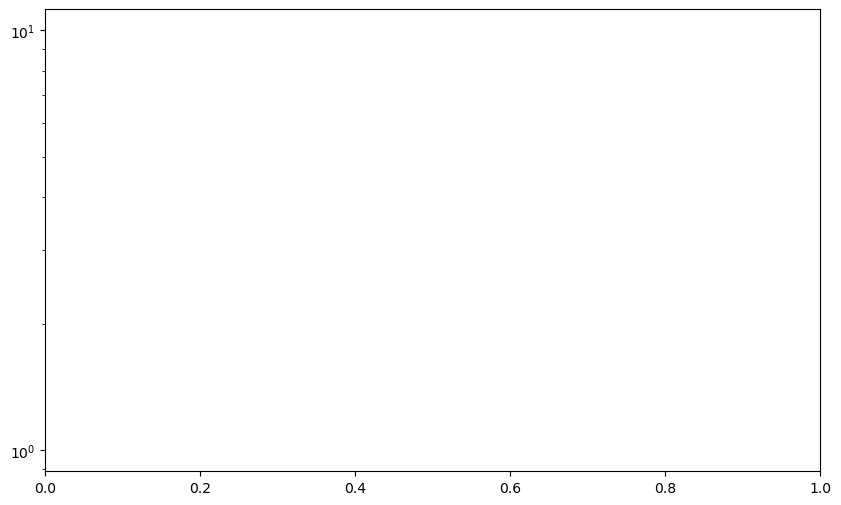

In [15]:
# Visualize Rayleigh optical thickness vs wavelength
#wavelengths = list(modis_bands.values())
bands = list(modis_bands.values())
tau_r_values = list(modis_rayleigh.values())

cen_waves = [items[0] for items in wavelengths]

plt.figure(figsize=(10, 6))
plt.semilogy(cen_waves, tau_r_values, 'bo-', markersize=10, linewidth=2)
plt.xlabel('Wavelength (nm)', fontsize=12)
plt.ylabel('Rayleigh Optical Thickness', fontsize=12)
plt.title('MODIS-Aqua: Rayleigh Optical Thickness vs Wavelength', fontsize=14)
plt.grid(True, alpha=0.3)

# Annotate bands
for wl, tau, band in zip(wavelengths, tau_r_values, modis_bands.keys()):
    plt.annotate(band, (wl, tau), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8)

plt.tight_layout()
plt.show()

## Gas Absorption Cross Sections

The package includes absorption cross sections for ozone (O3) and nitrogen dioxide (NO2) at each sensor's band wavelengths.

In [ ]:
# Ozone absorption cross sections for MODIS-Aqua
o3_cross = constants.O3_CROSS_SECTION['modis_aqua']

print("MODIS-Aqua O3 Absorption Cross Sections (cm^2/molecule):")
print("-" * 55)
for band, sigma in o3_cross.items():
    wavelength = modis_bands[band]
    print(f"  {band} ({wavelength} nm): sigma_O3 = {sigma:.4e}")

In [ ]:
# NO2 absorption cross sections
no2_cross = constants.NO2_CROSS_SECTION['modis_aqua']

print("\nMODIS-Aqua NO2 Absorption Cross Sections (cm^2/molecule):")
print("-" * 55)
for band, sigma in no2_cross.items():
    wavelength = modis_bands[band]
    print(f"  {band} ({wavelength} nm): sigma_NO2 = {sigma:.4e}")

## Pure Water Optical Properties

The package includes pure water absorption coefficients and backscatter coefficients needed for bio-optical algorithms.

In [ ]:
# Pure water absorption
aw = constants.PURE_WATER_ABS['modis_aqua']
bbw = constants.PURE_WATER_BB['modis_aqua']

print("MODIS-Aqua Pure Water Properties:")
print("-" * 50)
print(f"{'Band':<8} {'Wavelength':<12} {'a_w (m^-1)':<15} {'bb_w (m^-1)'}")
print("-" * 50)
for band in modis_bands.keys():
    wl = modis_bands[band]
    a = aw.get(band, 'N/A')
    bb = bbw.get(band, 'N/A')
    if isinstance(a, float):
        print(f"{band:<8} {wl:<12} {a:<15.6f} {bb:.6f}")
    else:
        print(f"{band:<8} {wl:<12} {a:<15} {bb}")

## Main Atmospheric Correction Class

The `AtmosphericCorrection` class is the primary interface for performing atmospheric corrections.

In [ ]:
from correct_atmosphere.correction import (
    AtmosphericCorrection,
    GeometryAngles,
    AncillaryData,
    CorrectionResult
)

# Create an atmospheric correction processor for MODIS-Aqua
ac = AtmosphericCorrection('modis_aqua')

print(f"Processor created for sensor: {ac.sensor}")
print(f"Available bands: {list(ac.bands.keys())}")

## Input Data Requirements

The atmospheric correction requires:

1. **Top-of-atmosphere radiances (Lt)** - Dictionary of radiance arrays keyed by band name
2. **Geometry angles** - Solar and viewing geometry
3. **Ancillary data** - Environmental parameters

In [ ]:
# Example: Create geometry angles
geometry = GeometryAngles(
    solar_zenith=30.0,      # degrees
    solar_azimuth=120.0,    # degrees
    view_zenith=15.0,       # degrees
    view_azimuth=90.0       # degrees
)

print("Geometry Angles:")
print(f"  Solar zenith: {geometry.solar_zenith}")
print(f"  Solar azimuth: {geometry.solar_azimuth}")
print(f"  View zenith: {geometry.view_zenith}")
print(f"  View azimuth: {geometry.view_azimuth}")

In [ ]:
# Example: Create ancillary data
ancillary = AncillaryData(
    pressure=1013.25,       # hPa (surface pressure)
    wind_speed=5.0,         # m/s
    ozone=300.0,            # Dobson Units
    water_vapor=1.5,        # g/cm^2
    relative_humidity=80.0, # percent
    no2_tropo=1.0e15,       # molecules/cm^2 (tropospheric NO2)
    no2_strato=2.0e15       # molecules/cm^2 (stratospheric NO2)
)

print("Ancillary Data:")
print(f"  Pressure: {ancillary.pressure} hPa")
print(f"  Wind speed: {ancillary.wind_speed} m/s")
print(f"  Ozone: {ancillary.ozone} DU")
print(f"  Water vapor: {ancillary.water_vapor} g/cm^2")
print(f"  Relative humidity: {ancillary.relative_humidity}%")

## Package Structure

The package is organized into modules for each component of the atmospheric correction:

| Module | Description |
|--------|-------------|
| `constants.py` | Physical constants and sensor parameters |
| `correction.py` | Main atmospheric correction class |
| `rayleigh.py` | Rayleigh scattering corrections |
| `gases.py` | Gaseous absorption corrections (O3, NO2) |
| `glint.py` | Sun glint correction |
| `whitecaps.py` | Whitecap/foam reflectance |
| `aerosols.py` | Aerosol path radiance estimation |
| `transmittance.py` | Atmospheric transmittance |
| `normalization.py` | Normalized reflectances and BRDF |
| `polarization.py` | Polarization sensitivity corrections |

## Next Steps

Continue with the following notebooks to learn more:

1. **02_physical_components.ipynb** - Rayleigh scattering, gas absorption, sun glint, and whitecaps
2. **03_aerosols_transmittance.ipynb** - Aerosol correction and atmospheric transmittance
3. **04_full_correction.ipynb** - Complete atmospheric correction workflow